# Set up

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


# RealCase

In [ ]:

SLICE_FILES = {
    "slice1": Path("slice1.csv"),
    "slice2": Path("slice2.csv"),
    "slice3": Path("slice3.csv"),
    "slice4": Path("slice4.csv"),
    "slice5": Path("slice5.csv"),
}

# 输出文件
OUT_TABLE = Path("AHA17_peak_strains_subset_2_to_-2_table.csv")  # 逐段表（1行/段）
OUT_ONE_ROW_FULL = Path("AHA17_one_row_full_labels_cir_then_rad_custom_order.csv")  # 单行（全称标签）
OUT_ONE_ROW_ABBR = Path("AHA17_one_row_abbr_labels_cir_then_rad_custom_order.csv")  # 单行（缩写标签）

# 列名使用全称(True)或缩写(False)
USE_FULL_LABELS = True

# 你给定的 16 段顺序（仅 1–16 段）
CUSTOM_ORDER_ABBR = [
    "Basal-InfSept", "Basal-AntSept", "Basal-Ant", "Basal-AntLat", "Basal-InfLat", "Basal-Inf",
    "Mid-InfSept", "Mid-AntSept", "Mid-Ant", "Mid-AntLat", "Mid-InfLat", "Mid-Inf",
    "Apical-Septal", "Apical-Anterior", "Apical-Lateral", "Apical-Inferior"
]

# =========================
# 辅助函数
# =========================
def subset_df(df: pd.DataFrame) -> pd.DataFrame:
    """仅保留第2行到倒数第2行；若行不足3，则返回空"""
    if len(df) < 3:
        return df.iloc[0:0].copy()
    return df.iloc[1:-1].reset_index(drop=True)

def pos_name(col: str) -> str:
    """将列名 'cirAntSeptTotal' / 'radInfLatTotal' 规范为位置名 'AntSept' / 'InfLat'"""
    name = col[3:]  # 去掉前缀 'cir' 或 'rad'
    if name.endswith("Total"):
        name = name[:-5]
    return name

def per_slice_extrema_on_subset(df: pd.DataFrame):
    """
    基于子集（去掉首尾行）计算单个 slice 极值：
    - cir_* 列取最小值
    - rad_* 列取最大值
    返回两个 dict：cir_min_map, rad_max_map（键：位置名，如 'Ant','InfSept' 等）
    """
    sub = subset_df(df)
    cir_cols = [c for c in sub.columns if c.startswith("cir")]
    rad_cols = [c for c in sub.columns if c.startswith("rad")]
    cir_min = {pos_name(c): (sub[c].min(skipna=True) if not sub.empty else float('nan'))
               for c in cir_cols}
    rad_max = {pos_name(c): (sub[c].max(skipna=True) if not sub.empty else float('nan'))
               for c in rad_cols}
    return cir_min, rad_max

def avg_maps(m1: dict, m2: dict) -> dict:
    """按键对两个映射做均值（忽略 NaN）"""
    keys = set(m1.keys()) | set(m2.keys())
    out = {}
    for k in keys:
        out[k] = pd.Series([m1.get(k, float('nan')), m2.get(k, float('nan'))]).mean(skipna=True)
    return out

def mean2(a, b):
    return pd.Series([a, b]).mean(skipna=True)

# 缩写→全称映射（环段位置）
ABBR_TO_FULL = {
    "Ant": "Anterior",
    "AntSept": "Anteroseptal",
    "InfSept": "Inferoseptal",
    "Inf": "Inferior",
    "InfLat": "Inferolateral",
    "AntLat": "Anterolateral",
    # 顶端象限（已是全称）
    "Septal": "Septal",
    "Anterior": "Anterior",
    "Lateral": "Lateral",
    "Inferior": "Inferior",
}

def to_full_label(label_abbr: str) -> str:
    """
    将 'Basal-InfSept' → 'Basal-Inferoseptal'
       'Apical-Septal' 保持不变
       'Apex (missing)' → 'Apex'
    """
    s = str(label_abbr).strip()
    if s.startswith("Apex"):
        return "Apex"
    if "-" in s:
        ring, pos = s.split("-", 1)
        full_pos = ABBR_TO_FULL.get(pos, pos)
        return f"{ring}-{full_pos}"
    return s

# =========================
# 计算流程
# =========================
# 1) 读取数据 + 各 slice 子集极值
s1 = pd.read_csv(SLICE_FILES["slice1"])
s2 = pd.read_csv(SLICE_FILES["slice2"])
s3 = pd.read_csv(SLICE_FILES["slice3"])
s4 = pd.read_csv(SLICE_FILES["slice4"])
s5 = pd.read_csv(SLICE_FILES["slice5"])

cir1, rad1 = per_slice_extrema_on_subset(s1)
cir2, rad2 = per_slice_extrema_on_subset(s2)
cir3, rad3 = per_slice_extrema_on_subset(s3)
cir4, rad4 = per_slice_extrema_on_subset(s4)
cir5_map, rad5_map = per_slice_extrema_on_subset(s5)

# 2) (slice1,slice2) 与 (slice3,slice4) 对应位置平均
cir12 = avg_maps(cir1, cir2)
rad12 = avg_maps(rad1, rad2)
cir34 = avg_maps(cir3, cir4)
rad34 = avg_maps(rad3, rad4)

# AHA 6 扇区顺序（环内位置的标准顺序）
AHA6 = ["Ant", "AntSept", "InfSept", "Inf", "InfLat", "AntLat"]

# 3) 组装 1–12 段（Basal、Mid）
rows = []
for i, pos in enumerate(AHA6, start=1):
    rows.append({
        "segment": i,
        "label_abbr": f"Basal-{pos}",
        "cir_min": cir12.get(pos, float('nan')),
        "rad_max": rad12.get(pos, float('nan'))
    })
for i, pos in enumerate(AHA6, start=7):
    rows.append({
        "segment": i,
        "label_abbr": f"Mid-{pos}",
        "cir_min": cir34.get(pos, float('nan')),
        "rad_max": rad34.get(pos, float('nan'))
    })

# 4) 组装 13–16 段（Apical，来自 slice5；按规则合并位置）
APICAL_RULES = [
    (13, "Apical-Anterior",  ("Ant",)),                      # 13=Ant
    (14, "Apical-Septal",    ("AntSept", "InfSept")),        # 14=mean(AntSept, InfSept)
    (15, "Apical-Inferior",  ("Inf",)),                      # 15=Inf
    (16, "Apical-Lateral",   ("AntLat", "InfLat")),          # 16=mean(AntLat, InfLat)
]
for seg, label_full, pos_tuple in APICAL_RULES:
    if len(pos_tuple) == 1:
        p = pos_tuple[0]
        cir_v = cir5_map.get(p, float('nan'))
        rad_v = rad5_map.get(p, float('nan'))
    else:
        cir_v = mean2(cir5_map.get(pos_tuple[0], float('nan')),
                      cir5_map.get(pos_tuple[1], float('nan')))
        rad_v = mean2(rad5_map.get(pos_tuple[0], float('nan')),
                      rad5_map.get(pos_tuple[1], float('nan')))
    # 这里 label_abbr 使用 'Apical-Anterior' 等（已是全称位置词）
    rows.append({
        "segment": seg,
        "label_abbr": label_full,  # 作为缩写标签使用（Apical-* 已是全称）
        "cir_min": cir_v,
        "rad_max": rad_v
    })

# 5) 17 段占位
rows.append({
    "segment": 17,
    "label_abbr": "Apex (missing)",
    "cir_min": float('nan'),
    "rad_max": float('nan')
})

table = pd.DataFrame(rows).sort_values("segment").reset_index(drop=True)

# 冗余一列：全称标签
table["label_full"] = table["label_abbr"].map(to_full_label)

# 保存逐段表（便于检查）
table[["segment", "label_abbr", "label_full", "cir_min", "rad_max"]].to_csv(OUT_TABLE, index=False)

# 6) 依据你给定的 16 段顺序（仅 1–16 段）构建单行输出
#    - 先 CIR 块（按顺序 16 列），再 RAD 块（按相同顺序 16 列）
#    - 列名可选：全称或缩写
order_abbr_16 = CUSTOM_ORDER_ABBR[:]  # 拷贝
# 构造查找表：abbr → 值（从 table 中取）
# 注意：table 中 apical 已采用全称词（Apical-Anterior 等），与 CUSTOM_ORDER_ABBR 的 Apical-* 保持一致
lookup_abbr_to_vals = {
    lab: table.loc[table["label_abbr"] == lab, ["cir_min", "rad_max"]].iloc[0].to_dict()
    for lab in table["label_abbr"].tolist()
    if lab != "Apex (missing)"
}

# 生成列名序列（根据 USE_FULL_LABELS 选择全称/缩写）
def col_name_base(label_abbr: str) -> str:
    return to_full_label(label_abbr) if USE_FULL_LABELS else label_abbr

cir_cols = [f"{col_name_base(lab)}_cir" for lab in order_abbr_16]
rad_cols = [f"{col_name_base(lab)}_rad" for lab in order_abbr_16]

# 生成对应取值（严格按顺序）
cir_vals = [lookup_abbr_to_vals.get(lab, {"cir_min": float('nan')})["cir_min"]
            for lab in order_abbr_16]
rad_vals = [lookup_abbr_to_vals.get(lab, {"rad_max": float('nan')})["rad_max"]
            for lab in order_abbr_16]

one_row = pd.DataFrame([cir_vals + rad_vals], columns=cir_cols + rad_cols)

# 输出文件（按标签样式选择）
if USE_FULL_LABELS:
    one_row.to_csv(OUT_ONE_ROW_FULL, index=False)
    print(f"Saved single-row (full labels) to: {OUT_ONE_ROW_FULL}")
else:
    one_row.to_csv(OUT_ONE_ROW_ABBR, index=False)
    print(f"Saved single-row (abbr labels) to: {OUT_ONE_ROW_ABBR}")


In [ ]:
SLICE_FILES = {
    "slice1": Path("slice1.csv"),
    "slice2": Path("slice2.csv"),
    "slice3": Path("slice3.csv"),
    "slice4": Path("slice4.csv"),
    "slice5": Path("slice5.csv"),
}

# 输出文件（注意：现在两个文件都会产生多行结果，并新增 source 列）
OUT_TABLE = Path("AHA17_subset_by_rows_table.csv")
OUT_ONE_ROW_FULL = Path("AHA17_rows_full_labels_cir_then_rad.csv")
OUT_ONE_ROW_ABBR = Path("AHA17_rows_abbr_labels_cir_then_rad.csv")

# 列名使用全称(True)或缩写(False)
USE_FULL_LABELS = True

# 你给定的 16 段顺序（仅 1–16 段）
CUSTOM_ORDER_ABBR = [
    "Basal-InfSept", "Basal-AntSept", "Basal-Ant", "Basal-AntLat", "Basal-InfLat", "Basal-Inf",
    "Mid-InfSept", "Mid-AntSept", "Mid-Ant", "Mid-AntLat", "Mid-InfLat", "Mid-Inf",
    "Apical-Septal", "Apical-Anterior", "Apical-Lateral", "Apical-Inferior"
]

# AHA 6 扇区顺序（环内位置的标准顺序）
AHA6 = ["Ant", "AntSept", "InfSept", "Inf", "InfLat", "AntLat"]

# Apical 规则（slice5）
APICAL_RULES = [
    (13, "Apical-Anterior",  ("Ant",)),                      # 13=Ant
    (14, "Apical-Septal",    ("AntSept", "InfSept")),        # 14=mean(AntSept, InfSept)
    (15, "Apical-Inferior",  ("Inf",)),                      # 15=Inf
    (16, "Apical-Lateral",   ("AntLat", "InfLat")),          # 16=mean(AntLat, InfLat)
]

# =========================
# 辅助函数
# =========================
def subset_df(df: pd.DataFrame) -> pd.DataFrame:
    """仅保留第2行到倒数第2行；若行不足3，则返回空"""
    if len(df) < 3:
        return df.iloc[0:0].copy()
    return df.iloc[1:-1].reset_index(drop=True)

def pos_name(col: str) -> str:
    """将列名 'cirAntSeptTotal' / 'radInfLatTotal' 规范为位置名 'AntSept' / 'InfLat'"""
    name = col[3:]  # 去掉前缀 'cir' 或 'rad'
    if name.endswith("Total"):
        name = name[:-5]
    return name

def per_slice_extrema_on_subset(df: pd.DataFrame):
    """
    极值行（第0行用）：基于子集（去掉首尾行）
    - cir_* 列取最小值
    - rad_* 列取最大值
    返回两个 dict：cir_min_map, rad_max_map（键：位置名）
    """
    sub = subset_df(df)
    cir_cols = [c for c in sub.columns if c.startswith("cir")]
    rad_cols = [c for c in sub.columns if c.startswith("rad")]
    if sub.empty:
        cir_min = {pos_name(c): float('nan') for c in cir_cols}
        rad_max = {pos_name(c): float('nan') for c in rad_cols}
    else:
        cir_min = {pos_name(c): sub[c].min(skipna=True) for c in cir_cols}
        rad_max = {pos_name(c): sub[c].max(skipna=True) for c in rad_cols}
    return cir_min, rad_max

def per_slice_row_values_on_subset(df: pd.DataFrame, row_idx: int):
    """
    行对齐法（第1..N行用）：基于子集（去掉首尾行）选取第 row_idx 行的**原始值**（不取极值/均值）
    返回两个 dict：cir_map, rad_map（键：位置名）
    """
    sub = subset_df(df)
    cir_cols = [c for c in sub.columns if c.startswith("cir")]
    rad_cols = [c for c in sub.columns if c.startswith("rad")]
    if row_idx < 0 or row_idx >= len(sub):
        # 越界时返回 NaN
        cir_map = {pos_name(c): float('nan') for c in cir_cols}
        rad_map = {pos_name(c): float('nan') for c in rad_cols}
    else:
        row = sub.iloc[row_idx]
        cir_map = {pos_name(c): row[c] for c in cir_cols}
        rad_map = {pos_name(c): row[c] for c in rad_cols}
    return cir_map, rad_map

def avg_maps(m1: dict, m2: dict) -> dict:
    """按键对两个映射做均值（忽略 NaN）"""
    keys = set(m1.keys()) | set(m2.keys())
    return {k: pd.Series([m1.get(k, float('nan')), m2.get(k, float('nan'))]).mean(skipna=True)
            for k in keys}

def mean2(a, b):
    return pd.Series([a, b]).mean(skipna=True)

# 缩写→全称映射（环段位置）
ABBR_TO_FULL = {
    "Ant": "Anterior",
    "AntSept": "Anteroseptal",
    "InfSept": "Inferoseptal",
    "Inf": "Inferior",
    "InfLat": "Inferolateral",
    "AntLat": "Anterolateral",
    # 顶端象限（已是全称）
    "Septal": "Septal",
    "Anterior": "Anterior",
    "Lateral": "Lateral",
    "Inferior": "Inferior",
}

def to_full_label(label_abbr: str) -> str:
    """'Basal-InfSept' → 'Basal-Inferoseptal'；'Apical-Septal' 保持；'Apex (missing)' → 'Apex'"""
    s = str(label_abbr).strip()
    if s.startswith("Apex"):
        return "Apex"
    if "-" in s:
        ring, pos = s.split("-", 1)
        full_pos = ABBR_TO_FULL.get(pos, pos)
        return f"{ring}-{full_pos}"
    return s

def build_aha17_rows(cir12: dict, rad12: dict, cir34: dict, rad34: dict,
                     cir5_map: dict, rad5_map: dict, source: str):
    """
    给定 Basal/Mid/Apical 三部分的映射，组装 AHA17（含占位17段）。
    返回：长表 rows_list（逐段）、以及宽表一行（先 CIR 16 列，再 RAD 16 列）。
    """
    rows = []
    # 1–12 段：Basal, Mid
    for i, pos in enumerate(AHA6, start=1):
        rows.append({
            "source": source,
            "segment": i,
            "label_abbr": f"Basal-{pos}",
            "cir": cir12.get(pos, float('nan')),
            "rad": rad12.get(pos, float('nan')),
        })
    for i, pos in enumerate(AHA6, start=7):
        rows.append({
            "source": source,
            "segment": i,
            "label_abbr": f"Mid-{pos}",
            "cir": cir34.get(pos, float('nan')),
            "rad": rad34.get(pos, float('nan')),
        })

    # 13–16 段：Apical（slice5）
    for seg, label_full, pos_tuple in APICAL_RULES:
        if len(pos_tuple) == 1:
            p = pos_tuple[0]
            cir_v = cir5_map.get(p, float('nan'))
            rad_v = rad5_map.get(p, float('nan'))
        else:
            cir_v = mean2(cir5_map.get(pos_tuple[0], float('nan')),
                          cir5_map.get(pos_tuple[1], float('nan')))
            rad_v = mean2(rad5_map.get(pos_tuple[0], float('nan')),
                          rad5_map.get(pos_tuple[1], float('nan')))
        rows.append({
            "source": source,
            "segment": seg,
            "label_abbr": label_full,
            "cir": cir_v,
            "rad": rad_v,
        })

    # 17 段占位
    rows.append({
        "source": source,
        "segment": 17,
        "label_abbr": "Apex (missing)",
        "cir": float('nan'),
        "rad": float('nan'),
    })

    # 加全称
    for r in rows:
        r["label_full"] = to_full_label(r["label_abbr"])

    # 宽表一行（仅 1–16 段，先 CIR 后 RAD）
    order_abbr_16 = CUSTOM_ORDER_ABBR[:]
    # 先做查找
    tmp_df = pd.DataFrame(rows)
    tmp_df16 = tmp_df[tmp_df["segment"] <= 16].copy()
    lookup = {
        lab: tmp_df16.loc[tmp_df16["label_abbr"] == lab, ["cir", "rad"]].iloc[0].to_dict()
        for lab in tmp_df16["label_abbr"].unique()
    }

    def col_name_base(label_abbr: str) -> str:
        return to_full_label(label_abbr) if USE_FULL_LABELS else label_abbr

    cir_cols = [f"{col_name_base(lab)}_cir" for lab in order_abbr_16]
    rad_cols = [f"{col_name_base(lab)}_rad" for lab in order_abbr_16]
    cir_vals = [lookup.get(lab, {"cir": float('nan')})["cir"] for lab in order_abbr_16]
    rad_vals = [lookup.get(lab, {"rad": float('nan')})["rad"] for lab in order_abbr_16]
    wide_row = {"source": source}
    wide_row.update({c: v for c, v in zip(cir_cols, cir_vals)})
    wide_row.update({c: v for c, v in zip(rad_cols, rad_vals)})

    return rows, wide_row

# =========================
# 主流程
# =========================
# 读取
s1 = pd.read_csv(SLICE_FILES["slice1"])
s2 = pd.read_csv(SLICE_FILES["slice2"])
s3 = pd.read_csv(SLICE_FILES["slice3"])
s4 = pd.read_csv(SLICE_FILES["slice4"])
s5 = pd.read_csv(SLICE_FILES["slice5"])

# 子集（去首尾）
sub1, sub2, sub3, sub4, sub5 = map(subset_df, [s1, s2, s3, s4, s5])

# --------- 第 0 行：极值法 ----------
cir1_ext, rad1_ext = per_slice_extrema_on_subset(s1)
cir2_ext, rad2_ext = per_slice_extrema_on_subset(s2)
cir3_ext, rad3_ext = per_slice_extrema_on_subset(s3)
cir4_ext, rad4_ext = per_slice_extrema_on_subset(s4)
cir5_ext, rad5_ext = per_slice_extrema_on_subset(s5)

cir12_ext = avg_maps(cir1_ext, cir2_ext)
rad12_ext = avg_maps(rad1_ext, rad2_ext)
cir34_ext = avg_maps(cir3_ext, cir4_ext)
rad34_ext = avg_maps(rad3_ext, rad4_ext)

rows_all, wide_all = [], []
rows0, wide0 = build_aha17_rows(cir12_ext, rad12_ext, cir34_ext, rad34_ext,
                                cir5_ext, rad5_ext, source="extrema")
rows_all.extend(rows0)
wide_all.append(wide0)

# --------- 后续行：行对齐法 ----------
len12 = min(len(sub1), len(sub2))
len34 = min(len(sub3), len(sub4))
len5  = len(sub5)
N = min(len12, len34, len5)

for k in range(N):
    cir1_k, rad1_k = per_slice_row_values_on_subset(s1, k)
    cir2_k, rad2_k = per_slice_row_values_on_subset(s2, k)
    cir3_k, rad3_k = per_slice_row_values_on_subset(s3, k)
    cir4_k, rad4_k = per_slice_row_values_on_subset(s4, k)
    cir5_k, rad5_k = per_slice_row_values_on_subset(s5, k)

    cir12_k = avg_maps(cir1_k, cir2_k)
    rad12_k = avg_maps(rad1_k, rad2_k)
    cir34_k = avg_maps(cir3_k, cir4_k)
    rad34_k = avg_maps(rad3_k, rad4_k)

    src = f"row_{k}"
    rows_k, wide_k = build_aha17_rows(cir12_k, rad12_k, cir34_k, rad34_k,
                                      cir5_k, rad5_k, source=src)
    rows_all.extend(rows_k)
    wide_all.append(wide_k)

# ========== 保存 ==========
# 长表（多行×17段）
table = pd.DataFrame(rows_all).sort_values(["source", "segment"]).reset_index(drop=True)
table.to_csv(OUT_TABLE, index=False)

# 宽表（多行×(1 + 32列)，含 source）
wide = pd.DataFrame(wide_all)
if USE_FULL_LABELS:
    wide.to_csv(OUT_ONE_ROW_FULL, index=False)
    print(f"Saved multi-row wide table (full labels) to: {OUT_ONE_ROW_FULL}")
else:
    wide.to_csv(OUT_ONE_ROW_ABBR, index=False)
    print(f"Saved multi-row wide table (abbr labels) to: {OUT_ONE_ROW_ABBR}")

print(f"Saved long table (per-segment) to: {OUT_TABLE}")


In [3]:
from pathlib import Path
import pandas as pd


# =========================
# 配置
# =========================
SLICE_FILES = {
    "slice1": Path("slice1.csv"),
    "slice2": Path("slice2.csv"),
    "slice3": Path("slice3.csv"),
    "slice4": Path("slice4.csv"),
    "slice5": Path("slice5.csv"),
}

# 输出文件（注意：现在两个文件都会产生多行结果，并新增 source 列）
OUT_TABLE = Path("AHA17_subset_by_rows_table.csv")
OUT_ONE_ROW_FULL = Path("AHA17_rows_full_labels_cir_then_rad.csv")
OUT_ONE_ROW_ABBR = Path("AHA17_rows_abbr_labels_cir_then_rad.csv")

# 列名使用全称(True)或缩写(False)
USE_FULL_LABELS = True

# 你给定的 16 段顺序（仅 1–16 段）
CUSTOM_ORDER_ABBR = [
    "Basal-InfSept", "Basal-AntSept", "Basal-Ant", "Basal-AntLat", "Basal-InfLat", "Basal-Inf",
    "Mid-InfSept", "Mid-AntSept", "Mid-Ant", "Mid-AntLat", "Mid-InfLat", "Mid-Inf",
    "Apical-Septal", "Apical-Anterior", "Apical-Lateral", "Apical-Inferior"
]

# AHA 6 扇区顺序（环内位置的标准顺序）
AHA6 = ["Ant", "AntSept", "InfSept", "Inf", "InfLat", "AntLat"]

# Apical 规则（slice5）
APICAL_RULES = [
    (13, "Apical-Anterior",  ("Ant",)),                      # 13=Ant
    (14, "Apical-Septal",    ("AntSept", "InfSept")),        # 14=mean(AntSept, InfSept)
    (15, "Apical-Inferior",  ("Inf",)),                      # 15=Inf
    (16, "Apical-Lateral",   ("AntLat", "InfLat")),          # 16=mean(AntLat, InfLat)
]


# =========================
# 辅助函数
# =========================
def subset_df(df: pd.DataFrame) -> pd.DataFrame:
    """仅保留第2行到倒数第2行；若行不足3，则返回空"""
    if len(df) < 3:
        return df.iloc[0:0].copy()
    return df.iloc[1:-1].reset_index(drop=True)


def pos_name(col: str) -> str:
    """将列名 'cirAntSeptTotal' / 'radInfLatTotal' 规范为位置名 'AntSept' / 'InfLat'"""
    name = col[3:]  # 去掉前缀 'cir' 或 'rad'
    if name.endswith("Total"):
        name = name[:-5]
    return name


def per_slice_extrema_on_subset(df: pd.DataFrame):
    """
    极值后一行（第0行用）：基于子集（去掉首尾行）
    - 对每个 cir_* 列：
        找到最小值所在行的“后一行”的值，若最小值在最后一行，则取最后一行。
    - 对每个 rad_* 列：
        找到最大值所在行的“后一行”的值，若最大值在最后一行，则取最后一行。
    返回两个 dict：cir_map, rad_map（键：位置名，例如 'AntSept'）
    """
    sub = subset_df(df)
    cir_cols = [c for c in sub.columns if c.startswith("cir")]
    rad_cols = [c for c in sub.columns if c.startswith("rad")]

    # 子集没有行 -> 全部 NaN
    if sub.empty:
        cir_map = {pos_name(c): float('nan') for c in cir_cols}
        rad_map = {pos_name(c): float('nan') for c in rad_cols}
        return cir_map, rad_map

    n_rows = len(sub)
    cir_map = {}
    rad_map = {}

    # cir_*：最小值所在行的后一行（最后一行特殊处理）
    for c in cir_cols:
        s = sub[c]
        valid = s.dropna()
        pos = pos_name(c)
        if valid.empty:
            cir_map[pos] = float('nan')
        else:
            # subset_df 已经 reset_index(drop=True)，索引为 0..n_rows-1
            idx_min = valid.idxmin()               # 极小值所在的行索引（按 label）
            use_idx = min(idx_min + 1, n_rows - 1) # 后一行；若已是最后一行，则仍用最后一行
            cir_map[pos] = sub[c].iloc[use_idx]

    # rad_*：最大值所在行的后一行（最后一行特殊处理）
    for c in rad_cols:
        s = sub[c]
        valid = s.dropna()
        pos = pos_name(c)
        if valid.empty:
            rad_map[pos] = float('nan')
        else:
            idx_max = valid.idxmax()
            use_idx = min(idx_max + 1, n_rows - 1)
            rad_map[pos] = sub[c].iloc[use_idx]

    return cir_map, rad_map


def per_slice_row_values_on_subset(df: pd.DataFrame, row_idx: int):
    """
    行对齐法（第1..N行用）：基于子集（去掉首尾行）选取第 row_idx 行的**原始值**（不取极值/均值）
    返回两个 dict：cir_map, rad_map（键：位置名）
    """
    sub = subset_df(df)
    cir_cols = [c for c in sub.columns if c.startswith("cir")]
    rad_cols = [c for c in sub.columns if c.startswith("rad")]
    if row_idx < 0 or row_idx >= len(sub):
        # 越界时返回 NaN
        cir_map = {pos_name(c): float('nan') for c in cir_cols}
        rad_map = {pos_name(c): float('nan') for c in rad_cols}
    else:
        row = sub.iloc[row_idx]
        cir_map = {pos_name(c): row[c] for c in cir_cols}
        rad_map = {pos_name(c): row[c] for c in rad_cols}
    return cir_map, rad_map


def avg_maps(m1: dict, m2: dict) -> dict:
    """按键对两个映射做均值（忽略 NaN）"""
    keys = set(m1.keys()) | set(m2.keys())
    return {
        k: pd.Series([m1.get(k, float('nan')), m2.get(k, float('nan'))]).mean(skipna=True)
        for k in keys
    }


def mean2(a, b):
    return pd.Series([a, b]).mean(skipna=True)


# 缩写→全称映射（环段位置）
ABBR_TO_FULL = {
    "Ant": "Anterior",
    "AntSept": "Anteroseptal",
    "InfSept": "Inferoseptal",
    "Inf": "Inferior",
    "InfLat": "Inferolateral",
    "AntLat": "Anterolateral",
    # 顶端象限（已是全称）
    "Septal": "Septal",
    "Anterior": "Anterior",
    "Lateral": "Lateral",
    "Inferior": "Inferior",
}


def to_full_label(label_abbr: str) -> str:
    """'Basal-InfSept' → 'Basal-Inferoseptal'；'Apical-Septal' 保持；'Apex (missing)' → 'Apex'"""
    s = str(label_abbr).strip()
    if s.startswith("Apex"):
        return "Apex"
    if "-" in s:
        ring, pos = s.split("-", 1)
        full_pos = ABBR_TO_FULL.get(pos, pos)
        return f"{ring}-{full_pos}"
    return s


def build_aha17_rows(cir12: dict, rad12: dict, cir34: dict, rad34: dict,
                     cir5_map: dict, rad5_map: dict, source: str):
    """
    给定 Basal/Mid/Apical 三部分的映射，组装 AHA17（含占位17段）。
    返回：长表 rows_list（逐段）、以及宽表一行（先 CIR 16 列，再 RAD 16 列）。
    """
    rows = []

    # 1–12 段：Basal, Mid
    # 1–6 Basal
    for i, pos in enumerate(AHA6, start=1):
        rows.append({
            "source": source,
            "segment": i,
            "label_abbr": f"Basal-{pos}",
            "cir": cir12.get(pos, float('nan')),
            "rad": rad12.get(pos, float('nan')),
        })
    # 7–12 Mid
    for i, pos in enumerate(AHA6, start=7):
        rows.append({
            "source": source,
            "segment": i,
            "label_abbr": f"Mid-{pos}",
            "cir": cir34.get(pos, float('nan')),
            "rad": rad34.get(pos, float('nan')),
        })

    # 13–16 段：Apical（slice5）
    for seg, label_full, pos_tuple in APICAL_RULES:
        if len(pos_tuple) == 1:
            p = pos_tuple[0]
            cir_v = cir5_map.get(p, float('nan'))
            rad_v = rad5_map.get(p, float('nan'))
        else:
            cir_v = mean2(
                cir5_map.get(pos_tuple[0], float('nan')),
                cir5_map.get(pos_tuple[1], float('nan')),
            )
            rad_v = mean2(
                rad5_map.get(pos_tuple[0], float('nan')),
                rad5_map.get(pos_tuple[1], float('nan')),
            )
        rows.append({
            "source": source,
            "segment": seg,
            "label_abbr": label_full,
            "cir": cir_v,
            "rad": rad_v,
        })

    # 17 段占位
    rows.append({
        "source": source,
        "segment": 17,
        "label_abbr": "Apex (missing)",
        "cir": float('nan'),
        "rad": float('nan'),
    })

    # 加全称
    for r in rows:
        r["label_full"] = to_full_label(r["label_abbr"])

    # 宽表一行（仅 1–16 段，先 CIR 后 RAD）
    order_abbr_16 = CUSTOM_ORDER_ABBR[:]
    tmp_df = pd.DataFrame(rows)
    tmp_df16 = tmp_df[tmp_df["segment"] <= 16].copy()
    lookup = {
        lab: tmp_df16.loc[tmp_df16["label_abbr"] == lab, ["cir", "rad"]].iloc[0].to_dict()
        for lab in tmp_df16["label_abbr"].unique()
    }

    def col_name_base(label_abbr: str) -> str:
        return to_full_label(label_abbr) if USE_FULL_LABELS else label_abbr

    cir_cols = [f"{col_name_base(lab)}_cir" for lab in order_abbr_16]
    rad_cols = [f"{col_name_base(lab)}_rad" for lab in order_abbr_16]
    cir_vals = [lookup.get(lab, {"cir": float('nan')})["cir"] for lab in order_abbr_16]
    rad_vals = [lookup.get(lab, {"rad": float('nan')})["rad"] for lab in order_abbr_16]

    wide_row = {"source": source}
    wide_row.update({c: v for c, v in zip(cir_cols, cir_vals)})
    wide_row.update({c: v for c, v in zip(rad_cols, rad_vals)})

    return rows, wide_row


# =========================
# 主流程
# =========================

# 读取
s1 = pd.read_csv(SLICE_FILES["slice1"])
s2 = pd.read_csv(SLICE_FILES["slice2"])
s3 = pd.read_csv(SLICE_FILES["slice3"])
s4 = pd.read_csv(SLICE_FILES["slice4"])
s5 = pd.read_csv(SLICE_FILES["slice5"])

# 子集（去首尾）——主要用于计算长度
sub1, sub2, sub3, sub4, sub5 = map(subset_df, [s1, s2, s3, s4, s5])

# --------- 第 0 行：极值后一行法 ----------
cir1_ext, rad1_ext = per_slice_extrema_on_subset(s1)
cir2_ext, rad2_ext = per_slice_extrema_on_subset(s2)
cir3_ext, rad3_ext = per_slice_extrema_on_subset(s3)
cir4_ext, rad4_ext = per_slice_extrema_on_subset(s4)
cir5_ext, rad5_ext = per_slice_extrema_on_subset(s5)

# slice1&2、slice3&4 做平均
cir12_ext = avg_maps(cir1_ext, cir2_ext)
rad12_ext = avg_maps(rad1_ext, rad2_ext)
cir34_ext = avg_maps(cir3_ext, cir4_ext)
rad34_ext = avg_maps(rad3_ext, rad4_ext)

rows_all, wide_all = [], []
rows0, wide0 = build_aha17_rows(
    cir12_ext, rad12_ext, cir34_ext, rad34_ext,
    cir5_ext, rad5_ext, source="extrema"
)
rows_all.extend(rows0)
wide_all.append(wide0)

# --------- 后续行：行对齐法 ----------
len12 = min(len(sub1), len(sub2))
len34 = min(len(sub3), len(sub4))
len5 = len(sub5)
N = min(len12, len34, len5)

for k in range(N):
    cir1_k, rad1_k = per_slice_row_values_on_subset(s1, k)
    cir2_k, rad2_k = per_slice_row_values_on_subset(s2, k)
    cir3_k, rad3_k = per_slice_row_values_on_subset(s3, k)
    cir4_k, rad4_k = per_slice_row_values_on_subset(s4, k)
    cir5_k, rad5_k = per_slice_row_values_on_subset(s5, k)

    cir12_k = avg_maps(cir1_k, cir2_k)
    rad12_k = avg_maps(rad1_k, rad2_k)
    cir34_k = avg_maps(cir3_k, cir4_k)
    rad34_k = avg_maps(rad3_k, rad4_k)

    src = f"row_{k}"
    rows_k, wide_k = build_aha17_rows(
        cir12_k, rad12_k, cir34_k, rad34_k,
        cir5_k, rad5_k, source=src
    )
    rows_all.extend(rows_k)
    wide_all.append(wide_k)

# ========== 保存 ==========

# 长表（多行×17段）
table = pd.DataFrame(rows_all).sort_values(["source", "segment"]).reset_index(drop=True)
table.to_csv(OUT_TABLE, index=False)

# 宽表（多行×(1 + 32列)，含 source）
wide = pd.DataFrame(wide_all)
if USE_FULL_LABELS:
    wide.to_csv(OUT_ONE_ROW_FULL, index=False)
    print(f"Saved multi-row wide table (full labels) to: {OUT_ONE_ROW_FULL}")
else:
    wide.to_csv(OUT_ONE_ROW_ABBR, index=False)
    print(f"Saved multi-row wide table (abbr labels) to: {OUT_ONE_ROW_ABBR}")

print(f"Saved long table (per-segment) to: {OUT_TABLE}")


Saved multi-row wide table (full labels) to: AHA17_rows_full_labels_cir_then_rad.csv
Saved long table (per-segment) to: AHA17_subset_by_rows_table.csv


## Final

In [2]:

# =========================
# 配置
# =========================
SLICE_FILES = {
    "slice1": Path("slice1.csv"),
    "slice2": Path("slice2.csv"),
    "slice3": Path("slice3.csv"),
    "slice4": Path("slice4.csv"),
    "slice5": Path("slice5.csv"),
}

# 输出文件（注意：现在两个文件都会产生多行结果，并新增 source 列）
OUT_TABLE = Path("AHA17_subset_by_rows_table.csv")
OUT_ONE_ROW_FULL = Path("AHA17_rows_full_labels_cir_then_rad.csv")
OUT_ONE_ROW_ABBR = Path("AHA17_rows_abbr_labels_cir_then_rad.csv")

# 列名使用全称(True)或缩写(False)
USE_FULL_LABELS = True

# 你给定的 16 段顺序（仅 1–16 段）
CUSTOM_ORDER_ABBR = [
    "Basal-InfSept", "Basal-AntSept", "Basal-Ant", "Basal-AntLat", "Basal-InfLat", "Basal-Inf",
    "Mid-InfSept", "Mid-AntSept", "Mid-Ant", "Mid-AntLat", "Mid-InfLat", "Mid-Inf",
    "Apical-Septal", "Apical-Anterior", "Apical-Lateral", "Apical-Inferior"
]

# AHA 6 扇区顺序（环内位置的标准顺序）
AHA6 = ["Ant", "AntSept", "InfSept", "Inf", "InfLat", "AntLat"]

# Apical 规则（slice5）
APICAL_RULES = [
    (13, "Apical-Anterior",  ("Ant",)),                      # 13=Ant
    (14, "Apical-Septal",    ("AntSept", "InfSept")),        # 14=mean(AntSept, InfSept)
    (15, "Apical-Inferior",  ("Inf",)),                      # 15=Inf
    (16, "Apical-Lateral",   ("AntLat", "InfLat")),          # 16=mean(AntLat, InfLat)
]

# =========================
# 辅助函数
# =========================
def subset_df(df: pd.DataFrame) -> pd.DataFrame:
    """仅保留第2行到倒数第2行；若行不足3，则返回空"""
    if len(df) < 3:
        return df.iloc[0:0].copy()
    return df.iloc[1:-1].reset_index(drop=True)


def pos_name(col: str) -> str:
    """将列名 'cirAntSeptTotal' / 'radInfLatTotal' 规范为位置名 'AntSept' / 'InfLat'"""
    name = col[3:]  # 去掉前缀 'cir' 或 'rad'
    if name.endswith("Total"):
        name = name[:-5]
    return name


def per_slice_extrema_on_subset(df: pd.DataFrame):
    """
    极值后两行（第0行用）：基于子集（去掉首尾行）
    - 对每个 cir_* 列：
        找到最小值所在行的“后两行”的值；
        若没有后两行则取后一行；若没有后一行则取极值本身。
    - 对每个 rad_* 列：
        找到最大值所在行的“后两行”的值；
        若没有后两行则取后一行；若没有后一行则取极值本身。
    返回两个 dict：cir_map, rad_map（键：位置名，例如 'AntSept'）
    """
    sub = subset_df(df)
    cir_cols = [c for c in sub.columns if c.startswith("cir")]
    rad_cols = [c for c in sub.columns if c.startswith("rad")]

    # 子集没有行 -> 全部 NaN
    if sub.empty:
        cir_map = {pos_name(c): float('nan') for c in cir_cols}
        rad_map = {pos_name(c): float('nan') for c in rad_cols}
        return cir_map, rad_map

    n_rows = len(sub)
    cir_map = {}
    rad_map = {}

    def pick_idx(idx_ext: int, n_rows: int) -> int:
        """优先 idx+2，其次 idx+1，再次 idx_ext（都在范围内才用）"""
        if idx_ext + 2 <= n_rows - 1:
            return idx_ext + 2
        if idx_ext + 1 <= n_rows - 1:
            return idx_ext + 1
        return idx_ext

    # cir_*：最小值所在行的后两行（不够则降级）
    for c in cir_cols:
        s = sub[c]
        valid = s.dropna()
        pos = pos_name(c)
        if valid.empty:
            cir_map[pos] = float('nan')
        else:
            idx_min = valid.idxmin()  # subset_df 已 reset_index(drop=True)，索引为 0..n_rows-1
            use_idx = pick_idx(idx_min, n_rows)
            cir_map[pos] = sub[c].iloc[use_idx]

    # rad_*：最大值所在行的后两行（不够则降级）
    for c in rad_cols:
        s = sub[c]
        valid = s.dropna()
        pos = pos_name(c)
        if valid.empty:
            rad_map[pos] = float('nan')
        else:
            idx_max = valid.idxmax()
            use_idx = pick_idx(idx_max, n_rows)
            rad_map[pos] = sub[c].iloc[use_idx]

    return cir_map, rad_map


def per_slice_row_values_on_subset(df: pd.DataFrame, row_idx: int):
    """
    行对齐法（第1..N行用）：基于子集（去掉首尾行）选取第 row_idx 行的**原始值**（不取极值/均值）
    返回两个 dict：cir_map, rad_map（键：位置名）
    """
    sub = subset_df(df)
    cir_cols = [c for c in sub.columns if c.startswith("cir")]
    rad_cols = [c for c in sub.columns if c.startswith("rad")]
    if row_idx < 0 or row_idx >= len(sub):
        # 越界时返回 NaN
        cir_map = {pos_name(c): float('nan') for c in cir_cols}
        rad_map = {pos_name(c): float('nan') for c in rad_cols}
    else:
        row = sub.iloc[row_idx]
        cir_map = {pos_name(c): row[c] for c in cir_cols}
        rad_map = {pos_name(c): row[c] for c in rad_cols}
    return cir_map, rad_map


def avg_maps(m1: dict, m2: dict) -> dict:
    """按键对两个映射做均值（忽略 NaN）"""
    keys = set(m1.keys()) | set(m2.keys())
    return {
        k: pd.Series([m1.get(k, float('nan')), m2.get(k, float('nan'))]).mean(skipna=True)
        for k in keys
    }


def mean2(a, b):
    return pd.Series([a, b]).mean(skipna=True)


# 缩写→全称映射（环段位置）
ABBR_TO_FULL = {
    "Ant": "Anterior",
    "AntSept": "Anteroseptal",
    "InfSept": "Inferoseptal",
    "Inf": "Inferior",
    "InfLat": "Inferolateral",
    "AntLat": "Anterolateral",
    # 顶端象限（已是全称）
    "Septal": "Septal",
    "Anterior": "Anterior",
    "Lateral": "Lateral",
    "Inferior": "Inferior",
}


def to_full_label(label_abbr: str) -> str:
    """'Basal-InfSept' → 'Basal-Inferoseptal'；'Apical-Septal' 保持；'Apex (missing)' → 'Apex'"""
    s = str(label_abbr).strip()
    if s.startswith("Apex"):
        return "Apex"
    if "-" in s:
        ring, pos = s.split("-", 1)
        full_pos = ABBR_TO_FULL.get(pos, pos)
        return f"{ring}-{full_pos}"
    return s


def build_aha17_rows(cir12: dict, rad12: dict, cir34: dict, rad34: dict,
                     cir5_map: dict, rad5_map: dict, source: str):
    """
    给定 Basal/Mid/Apical 三部分的映射，组装 AHA17（含占位17段）。
    返回：长表 rows_list（逐段）、以及宽表一行（先 CIR 16 列，再 RAD 16 列）。
    """
    rows = []

    # 1–12 段：Basal, Mid
    # 1–6 Basal
    for i, pos in enumerate(AHA6, start=1):
        rows.append({
            "source": source,
            "segment": i,
            "label_abbr": f"Basal-{pos}",
            "cir": cir12.get(pos, float('nan')),
            "rad": rad12.get(pos, float('nan')),
        })
    # 7–12 Mid
    for i, pos in enumerate(AHA6, start=7):
        rows.append({
            "source": source,
            "segment": i,
            "label_abbr": f"Mid-{pos}",
            "cir": cir34.get(pos, float('nan')),
            "rad": rad34.get(pos, float('nan')),
        })

    # 13–16 段：Apical（slice5）
    for seg, label_full, pos_tuple in APICAL_RULES:
        if len(pos_tuple) == 1:
            p = pos_tuple[0]
            cir_v = cir5_map.get(p, float('nan'))
            rad_v = rad5_map.get(p, float('nan'))
        else:
            cir_v = mean2(
                cir5_map.get(pos_tuple[0], float('nan')),
                cir5_map.get(pos_tuple[1], float('nan')),
            )
            rad_v = mean2(
                rad5_map.get(pos_tuple[0], float('nan')),
                rad5_map.get(pos_tuple[1], float('nan')),
            )
        rows.append({
            "source": source,
            "segment": seg,
            "label_abbr": label_full,
            "cir": cir_v,
            "rad": rad_v,
        })

    # 17 段占位
    rows.append({
        "source": source,
        "segment": 17,
        "label_abbr": "Apex (missing)",
        "cir": float('nan'),
        "rad": float('nan'),
    })

    # 加全称
    for r in rows:
        r["label_full"] = to_full_label(r["label_abbr"])

    # 宽表一行（仅 1–16 段，先 CIR 后 RAD）
    order_abbr_16 = CUSTOM_ORDER_ABBR[:]
    tmp_df = pd.DataFrame(rows)
    tmp_df16 = tmp_df[tmp_df["segment"] <= 16].copy()
    lookup = {
        lab: tmp_df16.loc[tmp_df16["label_abbr"] == lab, ["cir", "rad"]].iloc[0].to_dict()
        for lab in tmp_df16["label_abbr"].unique()
    }

    def col_name_base(label_abbr: str) -> str:
        return to_full_label(label_abbr) if USE_FULL_LABELS else label_abbr

    cir_cols = [f"{col_name_base(lab)}_cir" for lab in order_abbr_16]
    rad_cols = [f"{col_name_base(lab)}_rad" for lab in order_abbr_16]
    cir_vals = [lookup.get(lab, {"cir": float('nan')})["cir"] for lab in order_abbr_16]
    rad_vals = [lookup.get(lab, {"rad": float('nan')})["rad"] for lab in order_abbr_16]

    wide_row = {"source": source}
    wide_row.update({c: v for c, v in zip(cir_cols, cir_vals)})
    wide_row.update({c: v for c, v in zip(rad_cols, rad_vals)})

    return rows, wide_row


# =========================
# 主流程
# =========================

# 读取
s1 = pd.read_csv(SLICE_FILES["slice1"])
s2 = pd.read_csv(SLICE_FILES["slice2"])
s3 = pd.read_csv(SLICE_FILES["slice3"])
s4 = pd.read_csv(SLICE_FILES["slice4"])
s5 = pd.read_csv(SLICE_FILES["slice5"])

# 子集（去首尾）——主要用于计算长度
sub1, sub2, sub3, sub4, sub5 = map(subset_df, [s1, s2, s3, s4, s5])

# --------- 第 0 行：极值“后两行”法（新规则） ----------
cir1_ext, rad1_ext = per_slice_extrema_on_subset(s1)
cir2_ext, rad2_ext = per_slice_extrema_on_subset(s2)
cir3_ext, rad3_ext = per_slice_extrema_on_subset(s3)
cir4_ext, rad4_ext = per_slice_extrema_on_subset(s4)
cir5_ext, rad5_ext = per_slice_extrema_on_subset(s5)

# slice1&2、slice3&4 做平均
cir12_ext = avg_maps(cir1_ext, cir2_ext)
rad12_ext = avg_maps(rad1_ext, rad2_ext)
cir34_ext = avg_maps(cir3_ext, cir4_ext)
rad34_ext = avg_maps(rad3_ext, rad4_ext)

rows_all, wide_all = [], []
rows0, wide0 = build_aha17_rows(
    cir12_ext, rad12_ext, cir34_ext, rad34_ext,
    cir5_ext, rad5_ext, source="extrema"
)
rows_all.extend(rows0)
wide_all.append(wide0)

# --------- 后续行：行对齐法 ----------
len12 = min(len(sub1), len(sub2))
len34 = min(len(sub3), len(sub4))
len5 = len(sub5)
N = min(len12, len34, len5)

for k in range(N):
    cir1_k, rad1_k = per_slice_row_values_on_subset(s1, k)
    cir2_k, rad2_k = per_slice_row_values_on_subset(s2, k)
    cir3_k, rad3_k = per_slice_row_values_on_subset(s3, k)
    cir4_k, rad4_k = per_slice_row_values_on_subset(s4, k)
    cir5_k, rad5_k = per_slice_row_values_on_subset(s5, k)

    cir12_k = avg_maps(cir1_k, cir2_k)
    rad12_k = avg_maps(rad1_k, rad2_k)
    cir34_k = avg_maps(cir3_k, cir4_k)
    rad34_k = avg_maps(rad3_k, rad4_k)

    src = f"row_{k}"
    rows_k, wide_k = build_aha17_rows(
        cir12_k, rad12_k, cir34_k, rad34_k,
        cir5_k, rad5_k, source=src
    )
    rows_all.extend(rows_k)
    wide_all.append(wide_k)

# ========== 保存 ==========

# 长表（多行×17段）
table = pd.DataFrame(rows_all).sort_values(["source", "segment"]).reset_index(drop=True)
table.to_csv(OUT_TABLE, index=False)

# 宽表（多行×(1 + 32列)，含 source）
wide = pd.DataFrame(wide_all)
if USE_FULL_LABELS:
    wide.to_csv(OUT_ONE_ROW_FULL, index=False)
    print(f"Saved multi-row wide table (full labels) to: {OUT_ONE_ROW_FULL}")
else:
    wide.to_csv(OUT_ONE_ROW_ABBR, index=False)
    print(f"Saved multi-row wide table (abbr labels) to: {OUT_ONE_ROW_ABBR}")

print(f"Saved long table (per-segment) to: {OUT_TABLE}")


Saved multi-row wide table (full labels) to: AHA17_rows_full_labels_cir_then_rad.csv
Saved long table (per-segment) to: AHA17_subset_by_rows_table.csv


# Select Data

# PCA

In [2]:
X_train = pd.read_csv('RealCase_X_train.csv', header=None, delimiter=',').values

Y_train_std = pd.read_csv('RealCase_Y_train_std.csv', header=None, delimiter=',').values

X_test = pd.read_csv('RealCase_X_test.csv', header=None, delimiter=',').values

Y_test_std = pd.read_csv('RealCase_Y_test_std.csv', header=None, delimiter=',').values

In [3]:
RealCase = pd.read_csv('RealCase_Y.csv', header=None, delimiter=',').values

In [ ]:
AHA17_rows_full_labels_cir_then_rad = pd.read_csv('AHA17_rows_full_labels_cir_then_rad.csv', header=None, delimiter=',').values

In [ ]:
AHA17_rows_full_labels_cir_then_rad

In [ ]:
Y_train_std.shape

In [4]:
col_min = np.nanmin(Y_train_std, axis=0)
col_max = np.nanmax(Y_train_std, axis=0)


((RealCase >= col_min) & (RealCase <= col_max)).sum(axis=1)

array([30,  2,  6, 15, 27, 31, 32, 31, 32, 31, 31, 31, 32, 31, 30])

In [5]:
mask = (RealCase >= col_min) & (RealCase <= col_max)

In [ ]:
mask

In [4]:
Row_11 = RealCase[-3]

In [7]:
maskrow_11 = (Row_11 >= col_min) & (Row_11 <= col_max)

In [8]:
RealCase_11 = RealCase[:,maskrow_11]

In [9]:
Y_train_std_11 = Y_train_std[:,maskrow_11]
Y_test_std_11 = Y_test_std[:,maskrow_11]

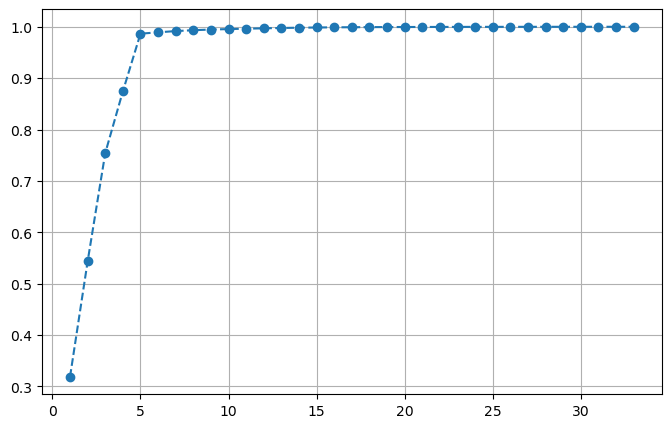

In [8]:
pca = PCA()

pca.fit(Y_train_std)

cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')

plt.grid()
plt.show()

In [9]:
np.argmax(cumulative_variance >= 0.999) + 1

17

In [10]:
def _sign_flip_scores(components, scores):

    comps = components.copy()
    Z = scores.copy()
    for i in range(comps.shape[0]):
        j = np.argmax(np.abs(comps[i]))  # 该成分绝对值最大的载荷索引
        if comps[i, j] < 0:              # 若为负则整体翻转
            comps[i] *= -1
            Z[:, i] *= -1
    return comps, Z

def split_and_apply_pca(train_data, test_data, RealCase_pca, variance_threshold=0.999,
                        svd_solver='full', random_state=0):


    train_first_col = train_data[:, 0].reshape(-1, 1)
    test_first_col  = test_data[:, 0].reshape(-1, 1)
    RealCase_first_col  = RealCase_pca[:, 0].reshape(-1, 1)

    train_remaining = train_data[:, 1:]
    test_remaining  = test_data[:, 1:]
    RealCase_remaining  = RealCase_pca[:, 1:]


    pca_full = PCA(svd_solver=svd_solver, random_state=random_state)
    pca_full.fit(train_remaining)
    cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)


    n_components = int(np.argmax(cumulative_variance >= variance_threshold) + 1)


    pca = PCA(n_components=n_components, svd_solver=svd_solver, random_state=random_state)
    train_scores = pca.fit_transform(train_remaining)  # Z_train
    test_scores  = pca.transform(test_remaining)       # Z_test
    RealCase_scores  = pca.transform(RealCase_remaining)       # Z_test

    # 5) 进行“符号固定”，消除 ± 号的随机性
    comps_fixed, train_scores_fixed = _sign_flip_scores(pca.components_, train_scores)
    _,           test_scores_fixed  = _sign_flip_scores(pca.components_, test_scores)
    _,           RealCase_scores_fixed  = _sign_flip_scores(pca.components_, RealCase_scores)

    # （可选）若你希望把固定后的 components 回写给 pca 对象，可取消下面两行注释：
    # pca.components_ = comps_fixed
    # 注意：scikit-learn 并不依赖 components_ 的符号唯一性，回写仅用于记录

    # 6) 合并回第一列
    train_final = np.hstack((train_first_col, train_scores_fixed))
    test_final  = np.hstack((test_first_col,  test_scores_fixed))
    RealCase_final  = np.hstack((RealCase_first_col,  RealCase_scores_fixed))

    return train_final, test_final, RealCase_final, n_components


In [12]:
Y_train_pca, Y_test_pca, RealCase_pca, n_components = split_and_apply_pca(Y_train_std, Y_test_std, RealCase)

In [13]:
n_components

17

In [14]:
col_min = np.nanmin(Y_train_pca, axis=0)
col_max = np.nanmax(Y_train_pca, axis=0)


((RealCase_pca >= col_min) & (RealCase_pca <= col_max)).sum(axis=1)

array([12, 15, 14, 14, 15, 14, 11, 11, 10, 10, 10, 10, 11, 11, 10])

In [15]:
mask = (RealCase_pca >= col_min) & (RealCase_pca <= col_max)

In [ ]:
mask

In [ ]:
np.savetxt("RealCase_Y_train_pca.csv", Y_train_pca, delimiter=",", fmt="%.8f")

np.savetxt("RealCase_Y_test_pca.csv", Y_test_pca, delimiter=",", fmt="%.8f")

np.savetxt("RealCase_Y_pca.csv", RealCase_pca, delimiter=",", fmt="%.8f")